In [1]:
######## Packages ########
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML 

## ギブスサンプリング
例として，2次元ガウス分布に対する変分推論を行う．
- 参考
    - https://learning-with-machine.hatenablog.com/entry/2019/12/05/193000
    
1次元のガウス分布からサンプルを得ることは容易だが，2次元のガウス分布からサンプルを得ることが困難であるとする．
$$
z = \left(
    \begin{array}{c}
        z_1 \\
        z_2
    \end{array}
    \right) \sim \mathcal{N}\left( \left. \left(
            \begin{array}{c}
                z_1 \\
                z_2
            \end{array}
        \right) \right| \left(
            \begin{array}{c}
                \mu_1 \\
                \mu_2
            \end{array}
        \right), \left(
                \begin{array}{cc}
                    \Sigma_{11} & \Sigma_{12} \\
                    \Sigma_{21} & \Sigma_{22}
                \end{array}
            \right)\right)
$$
とする．このとき，$z_1, z_2$の条件付き分布は次のようになる．
$$
p(z_2 | z_1) = \mathcal{N} (\mu_2 + \Sigma_{21}\Sigma_{11}^{-1}(z_1 - \mu_1), \Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12})
$$
逆は，
$$
p(z_1 | z_2) = \mathcal{N} (\mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(z_2 - \mu_2), \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21})
$$
で与えられる (佐和，回帰分析 新装版)．

In [2]:
################### Gibbs sampling ###################
def gibbs_norm(Z_init, mu, Sigma, n_sample):
    T = np.copy(Z_init).tolist()     # copy sample
    Z_new = [Z_init]                 # new sample
    dim_list = range(len(T))
    for roop in range(n_sample):
        for i in dim_list:
            ############ new distribution ##########
            key = list(set(dim_list) - {i})[0]
            mu_i = mu[i] + Sigma[i][key] / Sigma[key][key] * (T[key] - mu[key])
            s_i = Sigma[i][i] - Sigma[i][key] / Sigma[key][key] * Sigma[key][i]
            ########################################

            ############### new sample ###############
            sample_val = stats.norm.rvs(loc = mu_i, scale = np.sqrt(s_i), size = 1)[0]
            ##########################################

            ############### update t ###############
            T[i] = sample_val
            Z_new.append(np.array(T))
            ########################################
    return np.array(Z_new)
######################################################

In [3]:
#################### real ####################
dim = 2
mu_real = np.zeros(dim)
sigma_real = np.array([
    [1.0, 0.5], 
    [0.5, 1.0]
])
##############################################

In [4]:
#################### execute Gibbs sampling ####################
sample_size = 50
z_init = np.array([2, 1])
Z_sample = gibbs_norm(Z_init=z_init, mu=mu_real, Sigma=sigma_real, n_sample=sample_size)
################################################################

sample_mu = np.mean(Z_sample, axis=0)
sample_sigma = np.cov(Z_sample, rowvar=0)


In [5]:
# real distribution
z1, z2 = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))
pos = np.dstack((z1, z2))
norm_pdf_real = stats.multivariate_normal(mu_real, sigma_real).pdf(pos)

# sample distribution
norm_pdf_sample = stats.multivariate_normal(sample_mu, sample_sigma).pdf(pos)


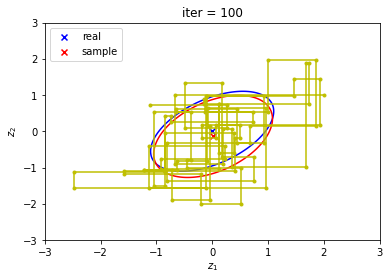

In [6]:
### plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_func(frame):
    ax.clear()
    ax.set_xlabel(r"$z_1$"); ax.set_ylabel(r"$z_2$")
    ax.set_title("iter = {}".format(frame))
    ax.set_xlim([-3, 3]); ax.set_ylim([-3, 3])
    ############################## real ##############################
    cont_real = ax.contour(z1, z2, norm_pdf_real, levels = [0.1], colors = 'blue')
    ax.scatter(mu_real[0], mu_real[1], marker='x', color = 'blue', label = 'real')  # mean
    ##################################################################

    ######################### sample #########################
    # ax.scatter(Z_sample[:,0], Z_sample[:,1], marker='o', color='y', s=10)
    ax.plot(Z_sample[:frame,0],Z_sample[:frame,1], '.-', c='y')
    if frame == len(Z_sample) - 1:
        cont_sample = ax.contour(z1, z2, norm_pdf_sample, levels = [0.1], colors = 'red')
        ax.scatter(sample_mu[0], sample_mu[1], marker='x', color='red', label='sample')
    ax.legend(loc = 'best')

ani = animation.FuncAnimation(fig, update_func, frames = len(Z_sample), interval = 200)
HTML(ani.to_jshtml())